# Testing regression model

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from models.utils import identify_device
from models.regression_utils import test_regression_model, load_regression_dataset, print_metrics_table, denormalize_material_params, normalize_material_params
from models.Regression_models import CNN1D_Regressor
from models.utils import display_model
from torch.nn import MSELoss

In [3]:
device = torch.device('cpu')
model = CNN1D_Regressor()
trained_model_name = 'regression_model_train_on_100k_clean_lr0_0001_epochs_200'
unseen_dataset_name = 'unseen_3_layer_nonoise_n1to8'
training_dataset = 'train_3_layer_nonoise_n1to8'


dataset = load_regression_dataset(f'regression_data/{unseen_dataset_name}.pt') # loads data and normalizes targets in dataset
unseen_loader = DataLoader(dataset, batch_size=1024)

model.load_state_dict(torch.load(f'trained_models/{trained_model_name}.pth', map_location=torch.device('cpu')))
model.to(device)

display_model(model, device=device)

Loading data from regression_data/unseen_3_layer_nonoise_n1to8.pt
Dataset loaded successfully!
Number of samples: 5000
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             384
         GroupNorm-2             [-1, 64, 1024]             128
         MaxPool1d-3              [-1, 64, 512]               0
            Conv1d-4             [-1, 128, 512]          41,088
         GroupNorm-5             [-1, 128, 512]             256
         MaxPool1d-6             [-1, 128, 256]               0
            Conv1d-7             [-1, 256, 256]          98,560
         GroupNorm-8             [-1, 256, 256]             512
         MaxPool1d-9             [-1, 256, 128]               0
           Conv1d-10             [-1, 256, 128]         196,864
        GroupNorm-11             [-1

In [4]:
metrics, results = test_regression_model(model, unseen_loader, device)
print_metrics_table(metrics, num_layers=3)


=== Scaled-domain metrics ===
| Param   |   RMSE |    MAE |     R² |
|---------|--------|--------|--------|
| n1      | 0.2058 | 0.1674 | 0.4693 |
| k1      | 0.2351 | 0.1954 | 0.3413 |
| d1      | 0.229  | 0.189  | 0.3745 |
| n2      | 0.108  | 0.0803 | 0.8562 |
| k2      | 0.2056 | 0.163  | 0.4902 |
| d2      | 0.1798 | 0.1387 | 0.6075 |
| n3      | 0.2098 | 0.172  | 0.4702 |
| k3      | 0.2369 | 0.196  | 0.3316 |
| d3      | 0.2282 | 0.1883 | 0.3785 |
| Mean    | 0.2043 | 0.1656 | 0.4799 |

=== Unscaled-domain metrics ===
| Param   |   RMSE |    MAE |     R² |   NRMSE |   MaxErr |   P95Err |
|---------|--------|--------|--------|---------|----------|----------|
| n1      | 1.4406 | 1.172  | 0.4693 |  0.2058 |   4.4294 |   2.7503 |
| k1      | 0.0237 | 0.0197 | 0.3413 |  0.2351 |   0.0707 |   0.0445 |
| d1      | 0.0001 | 0.0001 | 0.3745 |  0.229  |   0.0003 |   0.0002 |
| n2      | 0.7562 | 0.5618 | 0.8562 |  0.108  |   4.7604 |   1.545  |
| k2      | 0.0208 | 0.0165 | 0.4902 |  0.

In [5]:
index = 1
test_example_pulse = dataset[index][0]
test_example_true_vals = dataset[index][1]


print(denormalize_material_params(test_example_true_vals))

model.eval()
with torch.no_grad():
    pulse = test_example_pulse.unsqueeze(0).to(device)  # adjust based on original shape
    pred = model(pulse)
    pred = pred[0]
print(test_example_true_vals)
print(pred)

tensor([ 3.3356e+00, -2.9289e-02,  4.4947e-04,  3.1513e+00, -6.7920e-02,
         8.2824e-05,  7.5015e+00,  2.8881e-04,  2.2541e-04])
tensor([0.3337, 0.7001, 0.8877, 0.3073, 0.3176, 0.0729, 0.9288, 0.9930, 0.3898])
tensor([0.5977, 0.7824, 0.6391, 0.3122, 0.5681, 0.2550, 0.5996, 0.7806, 0.6366])


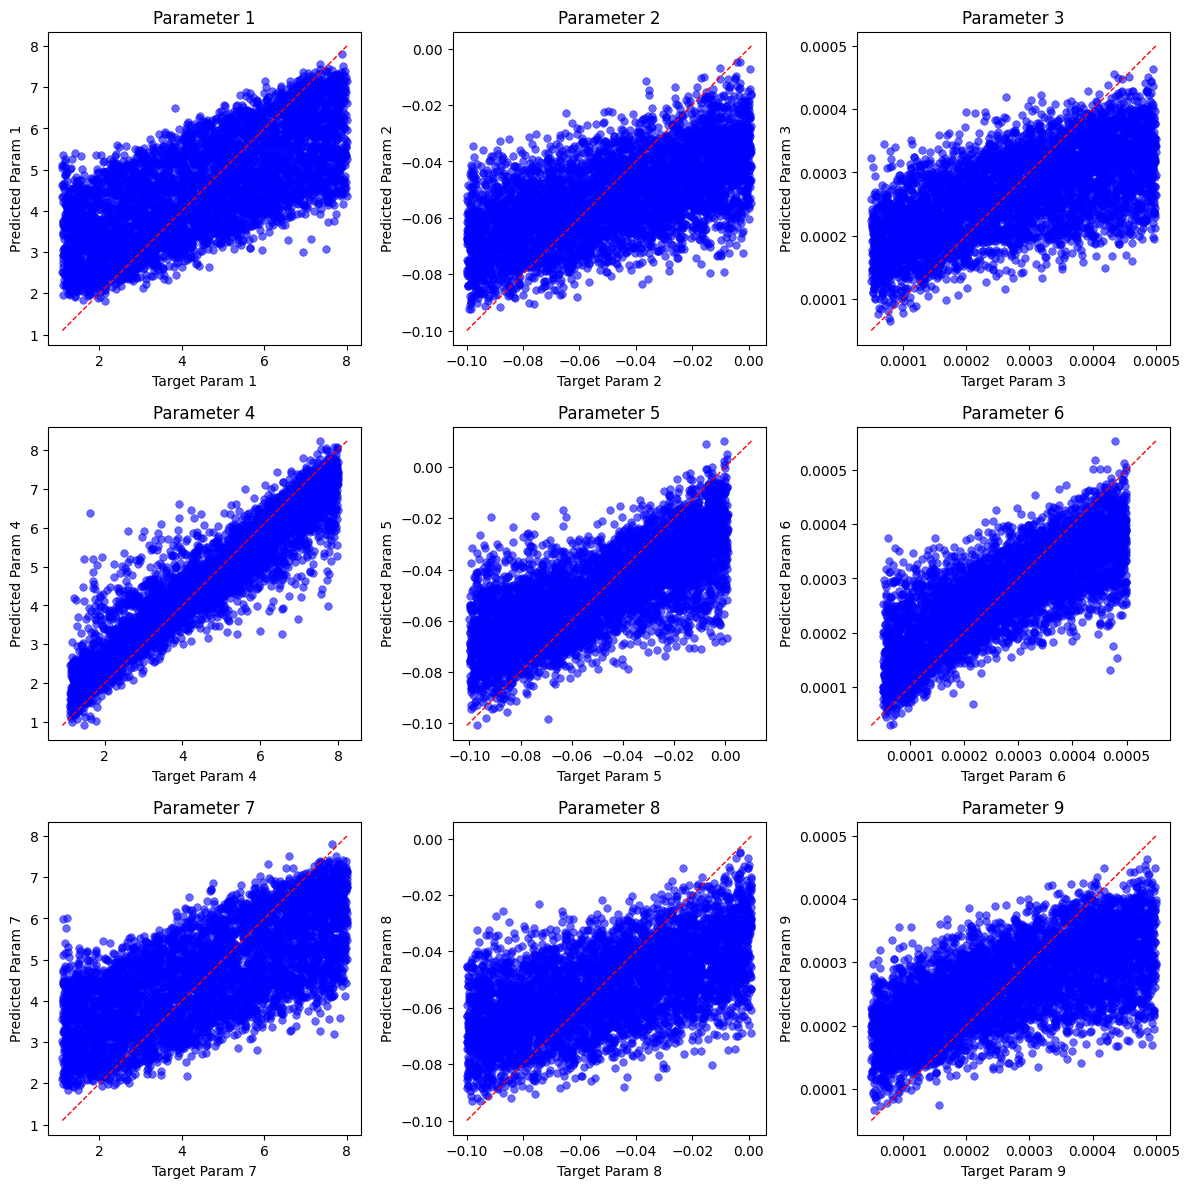

In [6]:
# Which to plot: change keys here
preds = results['preds_unscaled']
targets = results['targets_unscaled']

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    sns.scatterplot(x=targets[:, i], y=preds[:, i], ax=ax, s=30, color='blue', alpha=0.6, edgecolor=None)
    
    # Add 45° perfect prediction line
    min_val = min(targets[:, i].min(), preds[:, i].min())
    max_val = max(targets[:, i].max(), preds[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
    
    ax.set_xlabel(f"Target Param {i+1}")
    ax.set_ylabel(f"Predicted Param {i+1}")
    ax.set_title(f"Parameter {i+1}")
    ax.set_aspect('equal', adjustable='box')  # Keep scale equal

plt.tight_layout()
plt.show()

In [7]:
print(f"results scaled: {results['targets_scaled'][0]}")
print(f"\nresults unscaled: {results['targets_unscaled'][0]}")

print(f"\nDenormalized results scaled: {denormalize_material_params(results['targets_scaled'][0])}")
print(f"Denorm errors: {results['targets_unscaled'][0] - denormalize_material_params(results['targets_scaled'][0])}")

results scaled: tensor([0.7511, 0.7858, 0.4001, 0.1349, 0.6827, 0.4702, 0.7025, 0.6862, 0.1198])

results unscaled: tensor([ 6.2577e+00, -2.0639e-02,  2.3003e-04,  1.9441e+00, -3.1051e-02,
         2.6158e-04,  5.9178e+00, -3.0691e-02,  1.0389e-04])

Denormalized results scaled: tensor([ 6.2577e+00, -2.0639e-02,  2.3003e-04,  1.9441e+00, -3.1051e-02,
         2.6158e-04,  5.9178e+00, -3.0691e-02,  1.0389e-04])
Denorm errors: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [8]:
dataset[0][1]

tensor([0.7511, 0.7858, 0.4001, 0.1349, 0.6827, 0.4702, 0.7025, 0.6862, 0.1198])